# EDA

## Imports

In [1]:
import pandas as pd
import datatable as dt
import numpy as np
from scipy import stats

In [2]:
from typing import List, Callable
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load Dataset

X 데이터의 ID를 시계열로 봐야하나?

### Test X

In [4]:
test_x = pd.read_pickle('dataset/test_x.pkl')

In [5]:
test_x.shape

(171397, 669)

In [6]:
test_x.isna().sum().sum()

0

### Train X

In [7]:
%%time
train_x = pd.read_pickle('dataset/train_x.pkl')

CPU times: total: 578 ms
Wall time: 575 ms


In [8]:
id_grp = train_x.groupby('ID')
id_0 = id_grp.get_group(0)

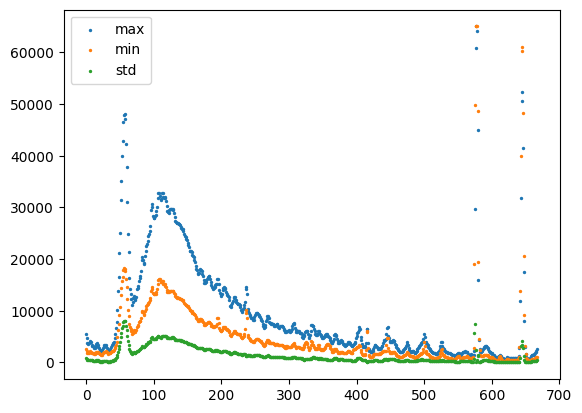

In [9]:
s = 2
x_tick = np.arange(0, 668, 1)

plt.scatter(x_tick, id_0.iloc[0, 1:], s=s, label='max')
plt.scatter(x_tick, id_0.iloc[1696, 1:], s=s, label='min')
plt.scatter(x_tick, id_grp.agg(np.std).iloc[0], s=s, label='std')
plt.legend();

In [10]:
train_x.shape

(685588, 669)

In [11]:
train_x.isna().sum().sum()

0

### Train Y

In [12]:
train_y = dt.fread('dataset/train_y.csv')
train_y = train_y.to_pandas()

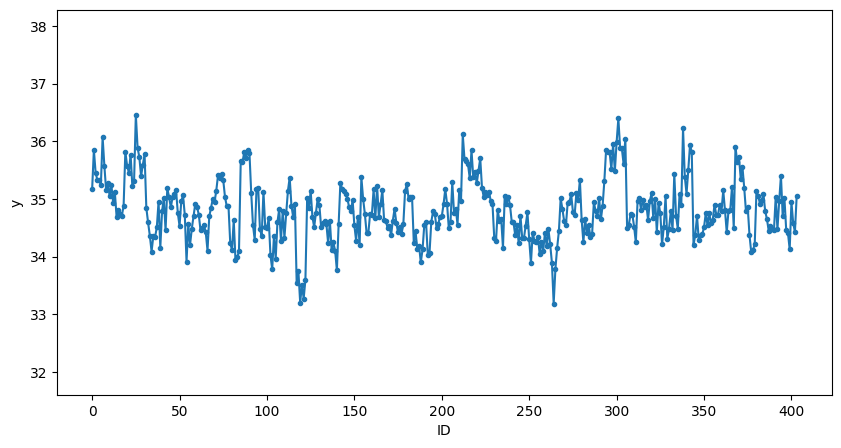

In [41]:
plt.figure(figsize=(10, 5))
y_min = train_y['y'].min()
y_max = train_y['y'].max()
plt.plot(train_y['y'], marker='o', markersize=3)
plt.ylim((y_min/1.05, y_max*1.05))
plt.xlabel('ID')
plt.ylabel('y')
plt.show()

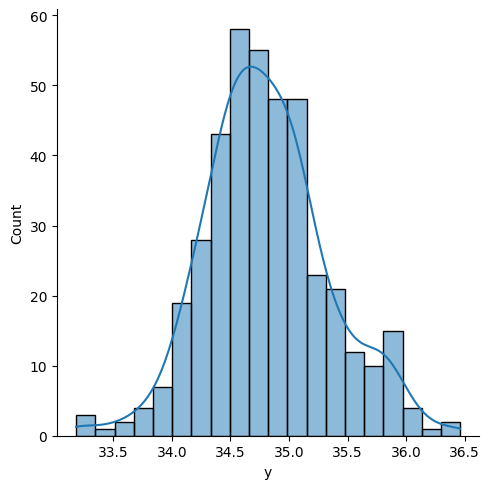

In [39]:
# y 분포
sns.displot(train_y['y'], kde=True)
plt.show()

In [25]:
mean_summary = id_grp.agg(np.mean)

In [ ]:
# See X and y
for x in range(668):
    x = str(x)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    y_min = train_y['y'].min()
    y_max = train_y['y'].max()
    color = 'tab:blue'
    ax1.plot(train_y['y'], marker='o', markersize=3, color=color)
    ax1.set_ylabel('y', color=color)
    ax1.tick_params('y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'orange'
    ax2.plot(mean_summary[x], marker='o', markersize=3, color=color)
    ax2.set_ylabel(f'X_{x}', color=color)
    ax2.tick_params('y', labelcolor=color)

    fig.tight_layout()
    plt.savefig(f'vis/x_and_y/X_{x}.png', dpi=100)
    plt.close()

Example:

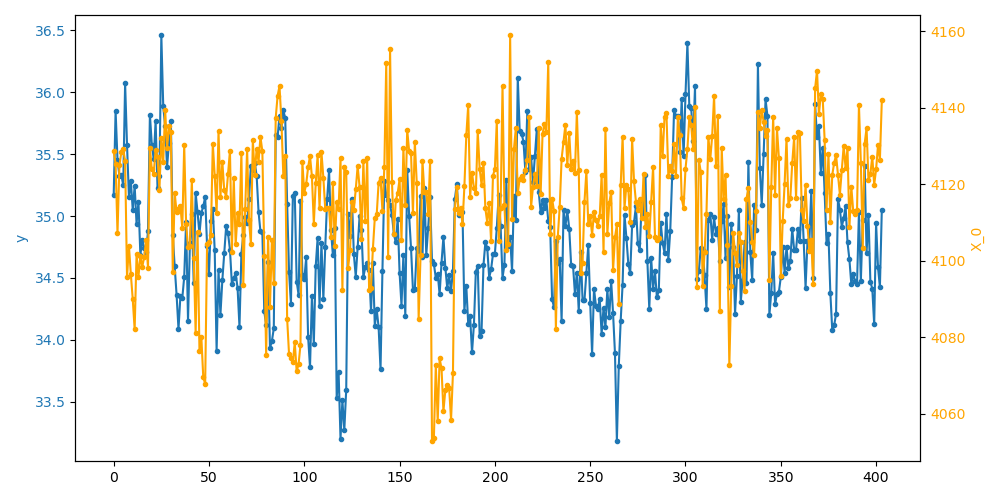

### Outlier Detection

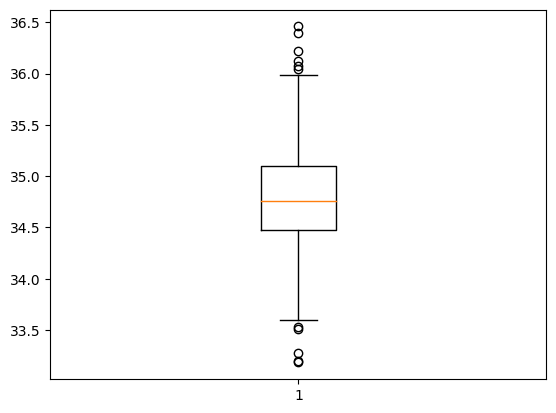

In [47]:
plt.boxplot(train_y['y'])
plt.show()

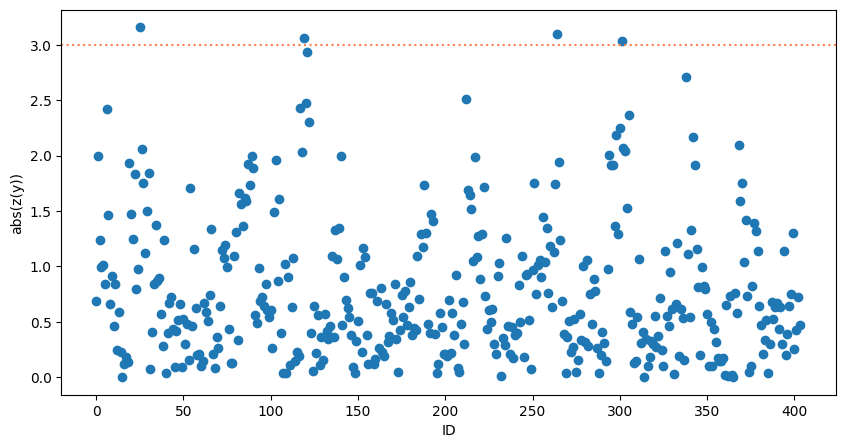

In [45]:
abs_z_score = np.abs(stats.zscore(train_y['y']))
id_len = len(train_y)
x = range(id_len)
plt.figure(figsize=(10, 5))
plt.scatter(x=x, y=abs_z_score)
plt.hlines(y=3.0, xmin=-20, xmax=id_len+20, color='coral', linestyle=':')
plt.margins(x=0)
plt.xlabel('ID')
plt.ylabel('abs(z(y))')
plt.show()

## EDA

In [48]:
def compare_x_scatter(df: pd.DataFrame, compare_x: List[str],
                      axs: List, y_margin=(0.05, 0.05)) -> None:
    id_len = df['ID'].nunique()
    for i in range(len(compare_x)):
        df_x = df[['ID', compare_x[i]]]
        
        for j in range(id_len):
            target = df_x.groupby('ID')
            grp = target[compare_x[i]].get_group(j).reset_index(drop=True)
            axs[i].scatter(x=range(len(grp)), y=grp, s=0.1)
            axs[i].set_title(f'Plot {i+1} (X={compare_x[i]})')
            axs[i].set_xlabel('t')

In [49]:
def compare_x_mean_median(compare_x: List[str], axs: List,
                          y_margin=(0.1, 0.1)) -> None:
    container = {}
    for x in compare_x:
        container[x] = {'stat': ['mean', 'median'],
                        'summary_val': [mean_df[x], median_df[x]]}

    x_axis = range(404)
    for i, k in enumerate(container.keys()):
        container[k]['ax'] = axs[i]
    for i, (k, v) in enumerate(container.items()):
        mean = v['summary_val'][0]
        median = v['summary_val'][1]
        y_min = np.min(mean) if np.min(mean) < np.min(median) else np.min(median)
        y_max = np.max(mean) if np.max(mean) > np.max(median) else np.max(median)
        y_min = y_min - (y_min * y_margin[0])
        y_max = y_max + (y_max * y_margin[1])
        for j in range(2):
            v['ax'].scatter(
                x=x_axis,
                y=v['summary_val'][j],
                label=v['stat'][j],
            )
            v['ax'].set_ylim((y_min, y_max))
            v['ax'].set_title(f'Plot {i + 1} (X={k})')
            v['ax'].set_xlabel('ID')
            v['ax'].legend()

### 1. Original Trace Data of Single X

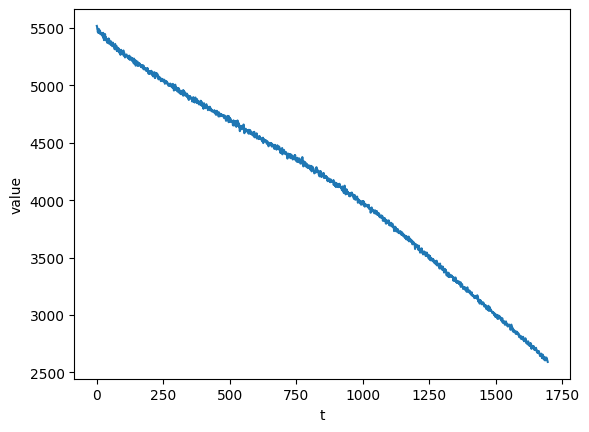

In [51]:
plt.plot(id_0['0'])
plt.xlabel('t')
plt.ylabel('value')
plt.show()

### 2. Trace Data of Single X for All ID

- Considering the dataset is a timeseries data, one should consider data drift

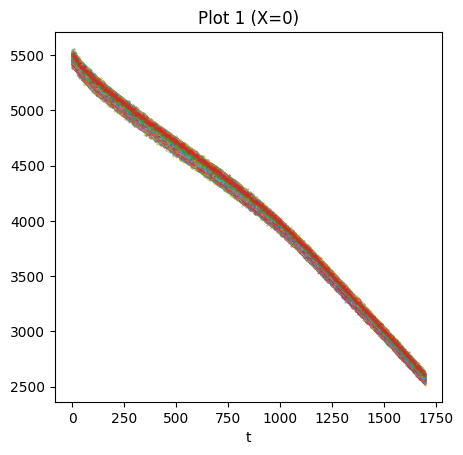

In [52]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(5)
compare_x_scatter(train_x, ['0'], [ax])
plt.show()

### 3. Sample Summary X

- Compare Mean and Median Summary X

In [53]:
mean_df = id_grp.agg(np.mean)
median_df = id_grp.agg(np.median)

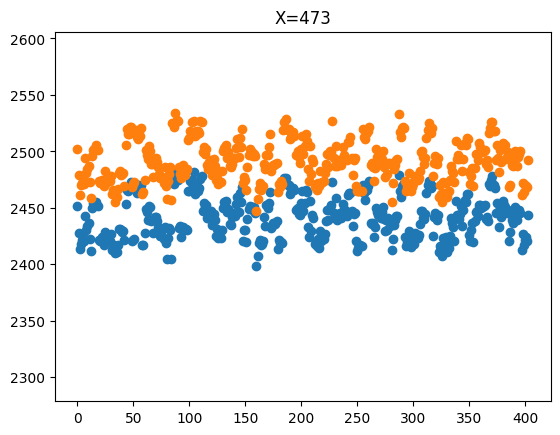

In [88]:
# Random Samples
sample = str(np.random.randint(0, len(mean_df.columns)))
y_len = len(mean_df)
plt.scatter(x=range(y_len), y=mean_df[sample])
plt.scatter(x=range(y_len), y=median_df[sample])
y_min = np.min(mean_df[sample]) - (np.min(mean_df[sample])*0.05)
y_max = np.max(mean_df[sample]) + (np.max(mean_df[sample])*0.05)
plt.title(f'X={sample}')
plt.ylim((y_min, y_max))
plt.show()

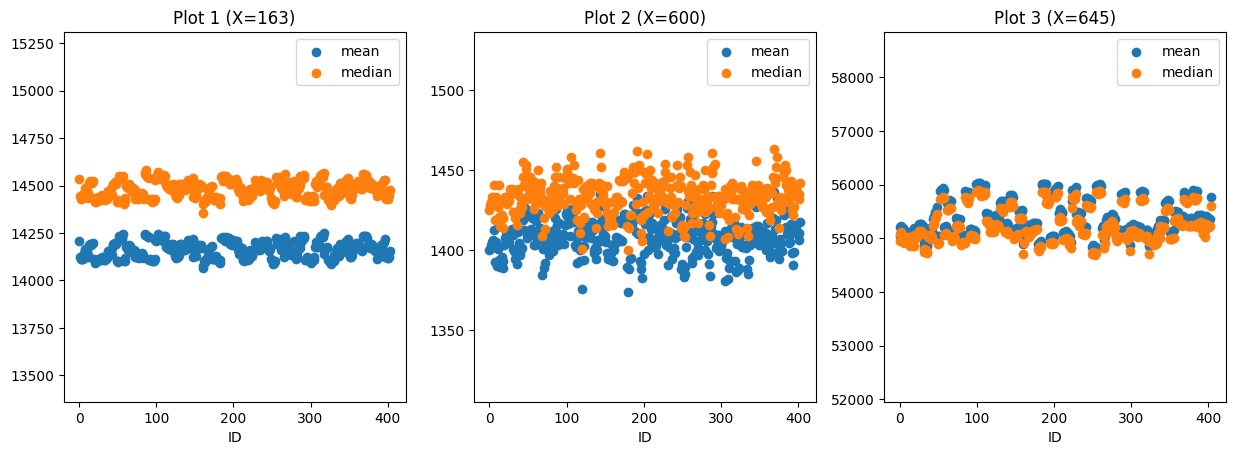

In [54]:
# Specific Samples
compare_x = ['163', '600', '645']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
compare_x_mean_median(compare_x, axs, y_margin=(0.05, 0.05))
plt.show()

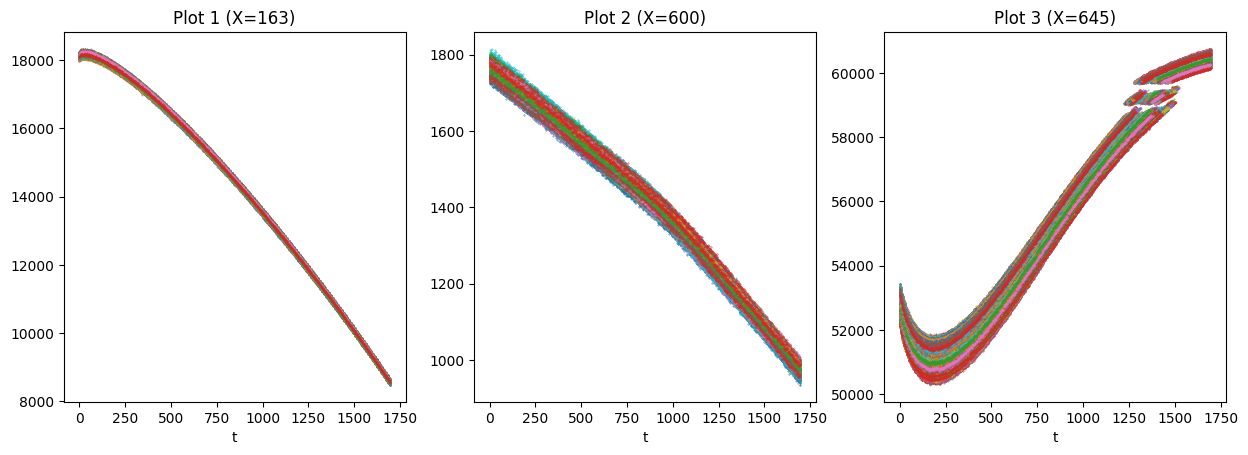

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
compare_x_scatter(train_x, compare_x, axs)
plt.show()

이상한 놈들이 좀 보임 (573~578)

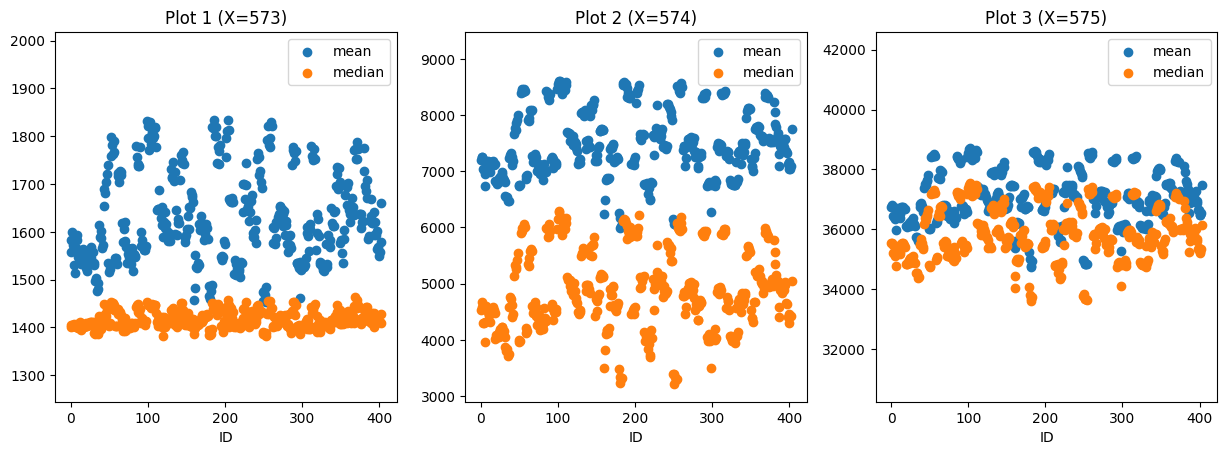

In [89]:
compare_x = ['573', '574', '575']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
compare_x_mean_median(compare_x, axs)
plt.show()

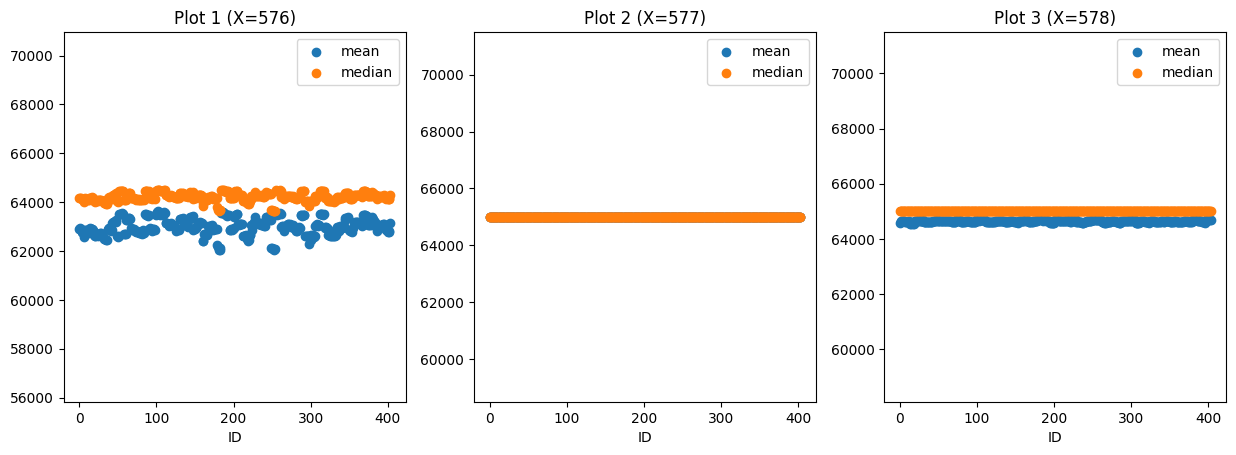

In [90]:
compare_x = ['576', '577', '578']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
compare_x_mean_median(compare_x, axs)
plt.show()

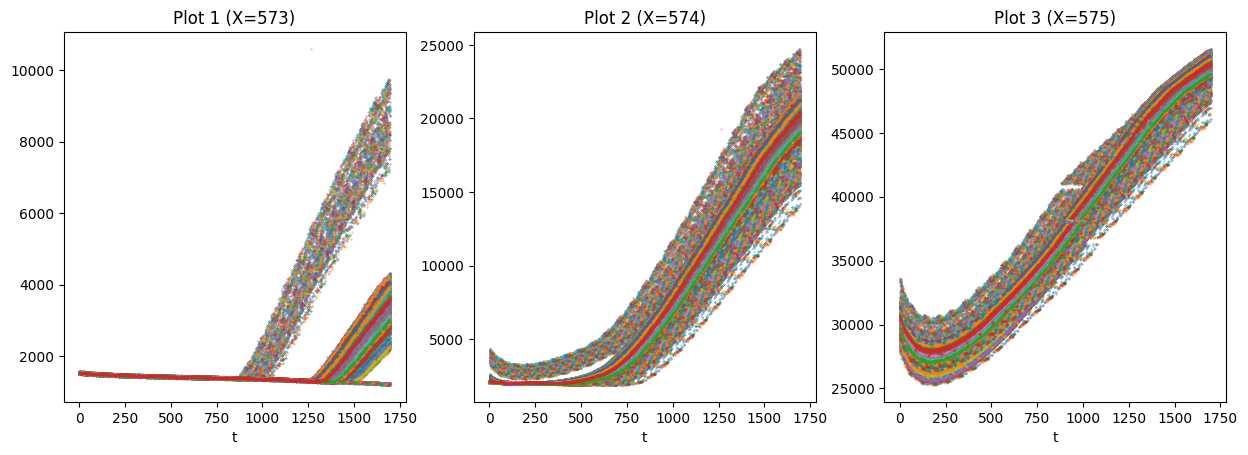

In [92]:
compare_x = ['573', '574', '575']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
df_target = compare_x_scatter(train_x, compare_x, axs, y_margin=(0.1, 0.1))
plt.show()

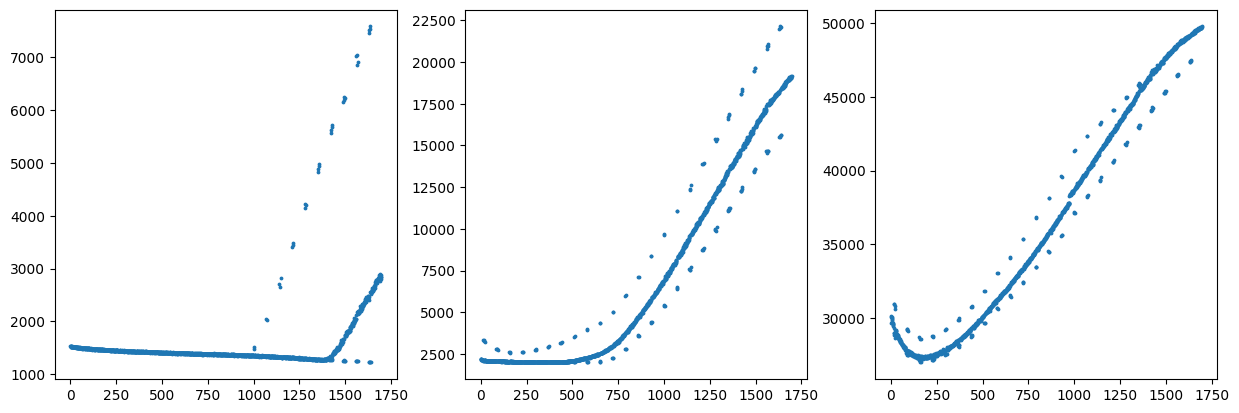

In [107]:
compare_x = ['573', '574', '575']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
for ax, x in zip(axs, compare_x):
    ax.scatter(range(len(id_0)), id_0[x], s=3)
plt.show()

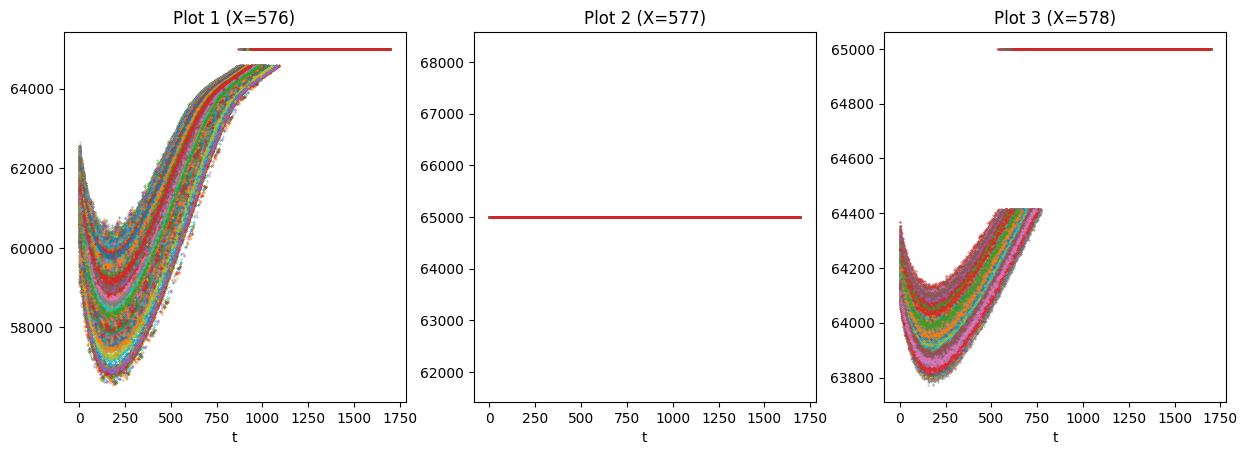

In [93]:
compare_x = ['576', '577', '578']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
df_target = compare_x_scatter(train_x, compare_x, axs)
plt.show()

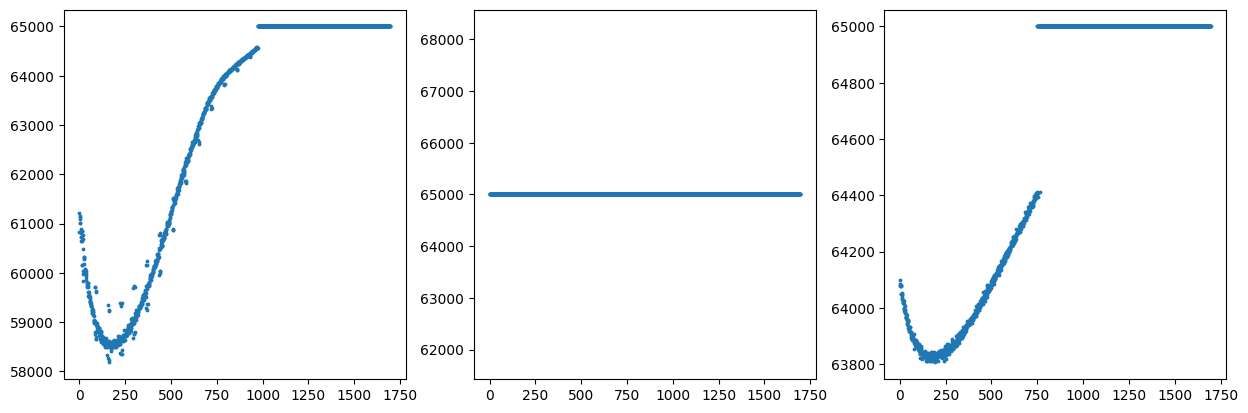

In [108]:
compare_x = ['576', '577', '578']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
axs = [ax1, ax2, ax3]
for ax, x in zip(axs, compare_x):
    ax.scatter(range(len(id_0)), id_0[x], s=3)
plt.show()

### 4. Types of Trace

In [110]:
from sklearn.preprocessing import scale

In [111]:
sc_id_zero = pd.DataFrame(scale(id_0), columns=id_0.columns)
sc_id_zero.reset_index(inplace=True)

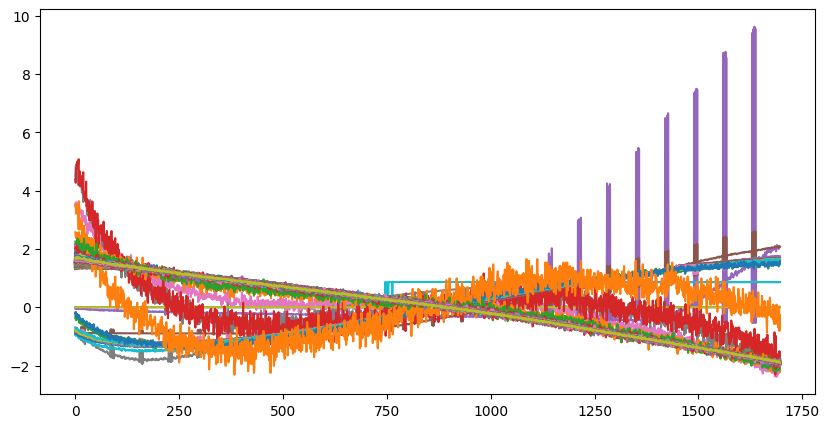

In [116]:
plt.figure(figsize=(10, 5))
for x in sc_id_zero.columns[1:]:
    plt.plot(sc_id_zero[x])
plt.show()

대략 5개 정도의 Trace data 유형이 있는듯

### 5. Plot all X values for single ID

- Check correlations between Xs

#### 5.1. Mean

In [123]:
mean_df = mean_df.drop(['576', '577', '578'], axis=1)
mean_df = pd.concat([train_y['y'], mean_df], axis=1)

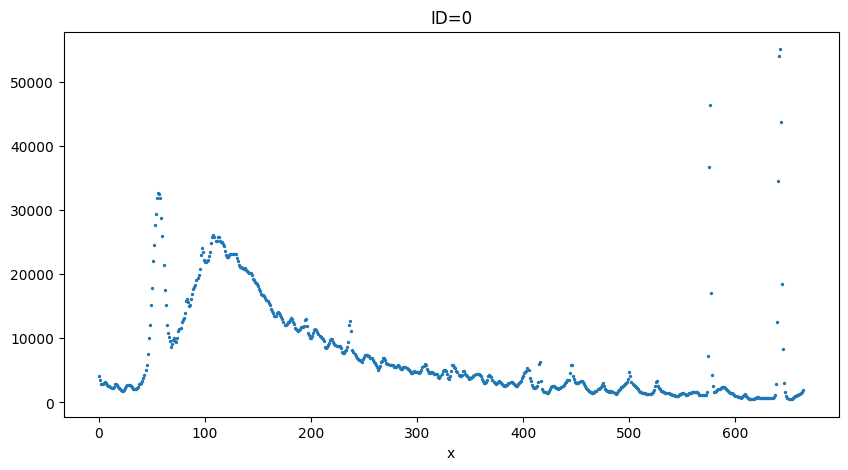

In [138]:
sample_id = 0
x_tick = len(mean_df.columns) - 1
plt.figure(figsize=(10, 5))
plt.scatter(list(range(x_tick)), mean_df.iloc[sample_id, 1:], s=2)
plt.title(f'ID={sample_id}')
plt.xlabel('x')
plt.show()

#### 5.2. Standard Deviation

- High std might be information about some meaningful reaction

In [139]:
train_x_std = id_grp.agg(np.std)

In [140]:
train_x_std = train_x_std.drop(['576', '577', '578'], axis=1)

In [141]:
std_df = pd.concat([train_y['y'], train_x_std], axis=1)

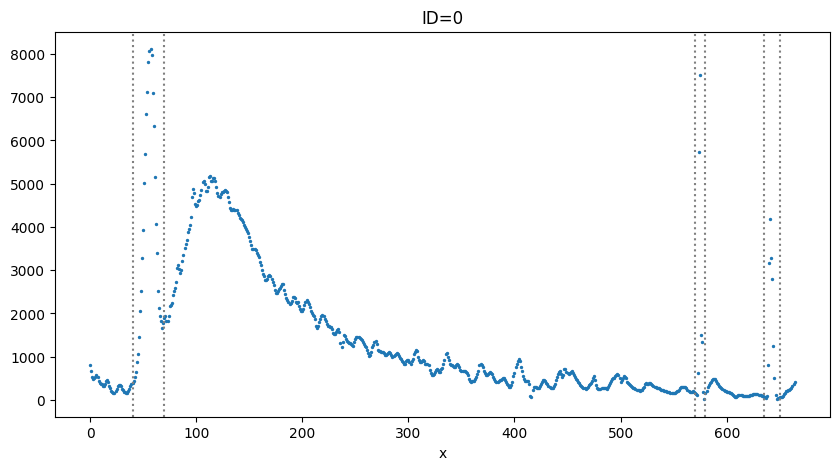

In [156]:
x_tick = len(std_df.columns) - 1
plt.figure(figsize=(10, 5))
plt.scatter(list(range(x_tick)), std_df.iloc[sample_id, 1:], s=2)

high_std_range_ = [40, 70, 570, 580, 635, 650]
for i in high_std_range_:
    plt.axvline(i, color='grey', linestyle=':')
    
plt.title(f'ID={sample_id}')
plt.xlabel('x')
plt.show()